# Analysis of ChIP-seq simulation

See 2023_chips for scripts.
Peak calling important: keep fixed settings.

```
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=100 span_params="--keep-cache --debug --noclip --blacklist /home/jetbrains/data/2023_wiggle/hg38-blacklist.v2.bed" --rerun-trigger mtime

```

In [85]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import os

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style("whitegrid")
import tempfile
import numpy as np

In [86]:
PATH = os.path.expanduser('~/data/2023_chips')
N = 5
MULTIPLIERS = [1.0, 0.7, 0.5, 0.2, 0.1]

FIGURES_DIR = f'{PATH}/pics'
! mkdir -p {FIGURES_DIR}
! rm {FIGURES_DIR}/*

# Chips models analysis

In [87]:
import json

models_df = pd.DataFrame(columns=['Modification', 'Model', 'k', 'theta', 'prc_rate', 'f', 's'],
                         dtype=object)
for modification in ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']:
    path = os.path.join(PATH, 'models', f'{modification}.json')
    with open(path) as f:
        m = json.load(f)
        k, theta, prc_rate, f, s = m['frag']['k'], m['frag']['theta'], m['pcr_rate'], \
            m['pulldown']['f'], m['pulldown']['s']
        models_df.loc[len(models_df)] = (modification, path, k, theta, prc_rate, f, s)
models_df.to_csv(os.path.join(PATH, 'models.tsv'), sep='\t', index=None)
models_df

Modification                                              Model         k  \
0      H3K27ac  /home/jetbrains/data/2023_chips/models/H3K27ac...  9.698845   
1     H3K27me3  /home/jetbrains/data/2023_chips/models/H3K27me...  7.710403   
2     H3K36me3  /home/jetbrains/data/2023_chips/models/H3K36me...  8.121823   
3      H3K4me1  /home/jetbrains/data/2023_chips/models/H3K4me1...  7.084311   
4      H3K4me3  /home/jetbrains/data/2023_chips/models/H3K4me3...  5.655991   

       theta  prc_rate         f         s  
0  28.720036       1.0  0.016691  0.543023  
1  32.211166       1.0  0.003799  0.186056  
2  31.384718       1.0  0.021185  0.649353  
3  33.604404       1.0  0.016509  0.742254  
4  37.608902       1.0  0.005437  0.738595

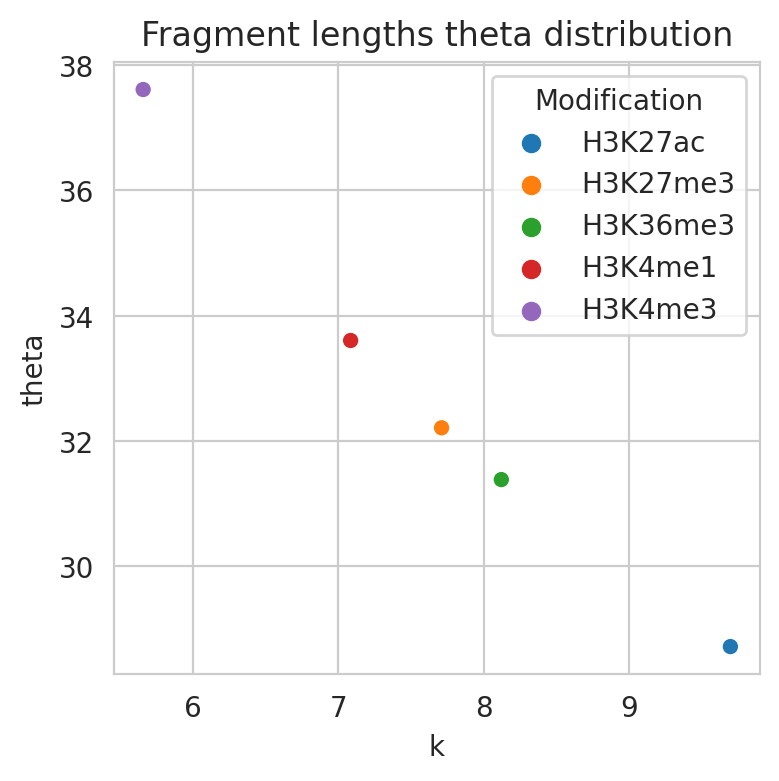

In [88]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='k', y='theta', hue='Modification', markers=True)
plt.title(f'Fragment lengths theta distribution')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_fragments_theta.pdf'), bbox_inches='tight', dpi=300)
plt.show()

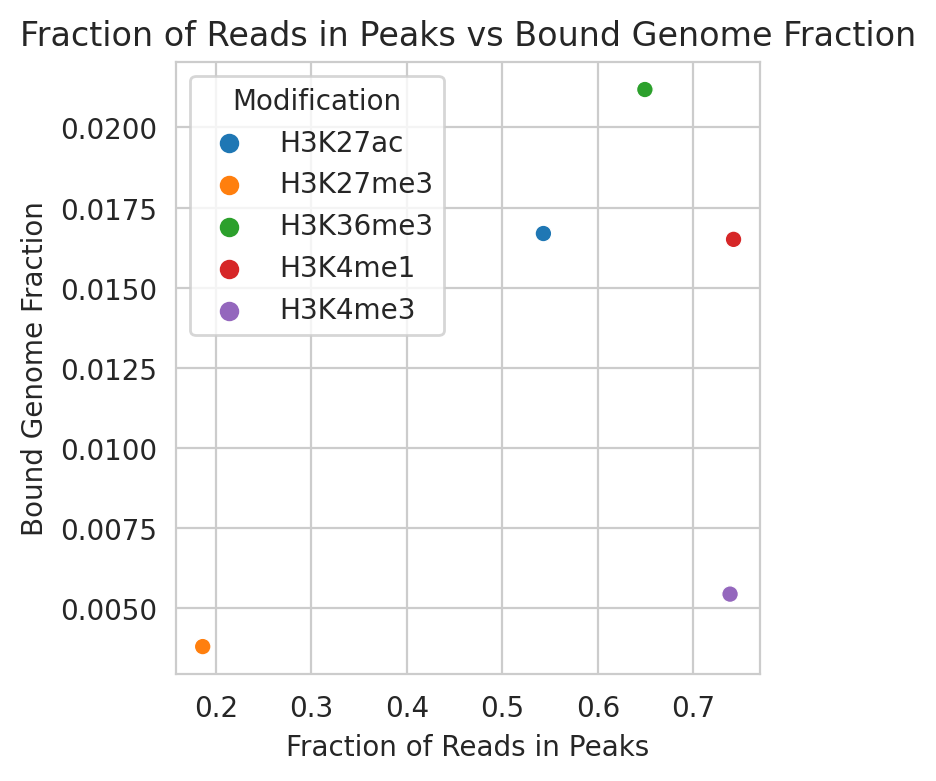

In [89]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='s', y='f', hue='Modification', markers=True)
plt.title(f'Fraction of Reads in Peaks vs Bound Genome Fraction')
plt.xlabel('Fraction of Reads in Peaks')
plt.ylabel('Bound Genome Fraction')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_frip_vs_bound_genome.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Report analysis

In [90]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

In [91]:
original_peaks = {
    'H3K4me3': PATH + '/peaks/H3K4me3_q0.05_peaks.narrowPeak',
    'H3K27ac': PATH + '/peaks/H3K27ac_broad0.1_peaks.broadPeak',
    'H3K4me1': PATH + '/peaks/H3K4me1_broad0.1_peaks.broadPeak',
    'H3K27me3' : PATH + '/peaks/H3K27me3-W200-G600-islands-summary-FDR0.01',
    'H3K36me3': PATH + '/peaks/H3K36me3-W200-G600-islands-summary-FDR0.01',
}

In [92]:
import glob
sampled_peaks = {}
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']:
    for n in range(1, N + 1):
        sampled_peaks[(m, n)] = glob.glob(PATH + f'/fastq/{m}_*_{n}.bed')[0]
sampled_peaks

{('H3K4me3', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_1.bed',
 ('H3K4me3', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_2.bed',
 ('H3K4me3', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_3.bed',
 ('H3K4me3', 4): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_4.bed',
 ('H3K4me3', 5): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_5.bed',
 ('H3K27ac', 1): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_1.bed',
 ('H3K27ac', 2): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_2.bed',
 ('H3K27ac', 3): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_3.bed',
 ('H3K27ac', 4): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_4.bed',
 ('H3K27ac', 5): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_5.bed',
 ('H3K4me1', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_1.bed',
 ('H3K4me1', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_2.bed',
 ('H3K4me1', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_

In [93]:
from itertools import product
def load_peaks(path, suffix):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'n', 'multiplier'], dtype=object)
    for (m, n, mult) in tqdm(product(
            ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], 
            range(1, N + 1), 
            MULTIPLIERS)):
        res = glob.glob(f'{path}/{m}*_{n}_{mult}*{suffix}')
        if len(res) > 1:
            print(f'WARNING, more than 1 found for {path} {suffix}')
        for f in res:
            df_fdr.loc[len(df_fdr)] = (f, m, n, mult)
    return df_fdr

# Load peaks

In [129]:
df_macs2 = load_peaks(PATH + '/macs2', '.narrowPeak')
df_macs2['tool'] = 'MACS2'
print('MACS2', len(df_macs2))
df_macs2broad = load_peaks(PATH + '/macs2', '.broadPeak')
df_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_macs2broad))
df_sicer = load_peaks(PATH + '/sicer', 'FDR0.01')
df_sicer['tool'] = 'SICER'
print('SICER', len(df_sicer))
df_span = load_peaks(PATH + '/span', '.peak')
df_span['tool'] = 'SPAN'
print('SPAN', len(df_span))

df_peaks = pd.concat([df_macs2, df_macs2broad, df_span, df_sicer]).reset_index(drop=True)
df_peaks['quality'] = [f'{int(m * 100)}%' for m in df_peaks['multiplier']]
df_peaks.sample(5)

0it [00:00, ?it/s]

MACS2 150


0it [00:00, ?it/s]

MACS2 broad 150


0it [00:00, ?it/s]

SICER 150


0it [00:00, ?it/s]

SPAN 150


file modification  n  \
44   /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      H3K27ac  4   
524  /home/jetbrains/data/2023_chips/sicer/H3K4me1_...      H3K4me1  5   
526  /home/jetbrains/data/2023_chips/sicer/H3K27me3...     H3K27me3  1   
523  /home/jetbrains/data/2023_chips/sicer/H3K4me1_...      H3K4me1  5   
385  /home/jetbrains/data/2023_chips/span/H3K27me3_...     H3K27me3  3   

     multiplier   tool quality  
44          0.1  MACS2     10%  
524         0.1  SICER     10%  
526         0.7  SICER     70%  
523         0.2  SICER     20%  
385         1.0   SPAN    100%

# Estimate overlap with ground truth peaks

In [130]:
tf = tempfile.mktemp()
t = []
for _, (file, m, n) in tqdm(df_peaks[['file', 'modification', 'n']].iterrows()):
    true_peaks_file = sampled_peaks[(m, n)]
    true_peaks = lines(true_peaks_file)
    true_length = bedl(true_peaks_file).sum()
    peaks = lines(file)
    length = bedl(file).sum()
    true_peaks_file_s = sorted_file(true_peaks_file)
    file_s = sorted_file(file)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wa -u > {tf}
    true_overlap = lines(tf)
    !bedtools intersect -b {true_peaks_file_s} -a {file_s} -wa -u > {tf}
    overlap = lines(tf)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    t.append((true_peaks_file, true_peaks, true_length, peaks, length, true_overlap, overlap, overlap_len))
    
t = pd.DataFrame(t, columns=['true_peaks_file', 'true_peaks', 'true_length',
                             'peaks', 'length', 
                             'true_overlap', 'overlap', 'overlap_len'])
for c in t.columns:
    df_peaks[c] = list(t[c])
del t

df_peaks['Precision'] = df_peaks['overlap'] / df_peaks['peaks']
df_peaks['Recall'] = df_peaks['true_overlap'] / df_peaks['true_peaks']
df_peaks['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df_peaks['Precision'], df_peaks['Recall'])]
df_peaks['Jaccard'] = df_peaks['overlap_len'] / (df_peaks['true_length'] + df_peaks['length'] - df_peaks['overlap_len'])


df_peaks.sample(5)

0it [00:00, ?it/s]

file modification  n  \
254  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  1   
509  /home/jetbrains/data/2023_chips/sicer/H3K4me1_...      H3K4me1  2   
512  /home/jetbrains/data/2023_chips/sicer/H3K4me1_...      H3K4me1  3   
209  /home/jetbrains/data/2023_chips/macs2/H3K4me1_...      H3K4me1  2   
559  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  2   

     multiplier         tool quality  \
254         0.1  MACS2 broad     10%   
509         0.1        SICER     10%   
512         0.5        SICER     50%   
209         0.1  MACS2 broad     10%   
559         0.1        SICER     10%   

                                       true_peaks_file  true_peaks  \
254  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
509  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
512  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
209  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
559  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   

     true_length  peaks     length  true_overlap  overlap  overlap_len  \
254      6726500    202    90363.0            79      202        90363   
509       568720   1360  2165440.0           232      234       388425   
512       562428    907  1461293.0           455      455       544512   
209       568720      0        0.0             0        0            0   
559      6942900    915  5774485.0           309      584      5241393   

     Precision  Recall        F1   Jaccard  
254   1.000000   0.158  0.272884  0.013434  
509   0.172059   0.464  0.251031  0.165588  
512   0.501654   0.910  0.646766  0.368110  
209        NaN   0.000  0.000000  0.000000  
559   0.638251   0.618  0.627962  0.701097

# Peaks number and lengths

In [131]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

/tmp/ipykernel_3046370/386494431.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


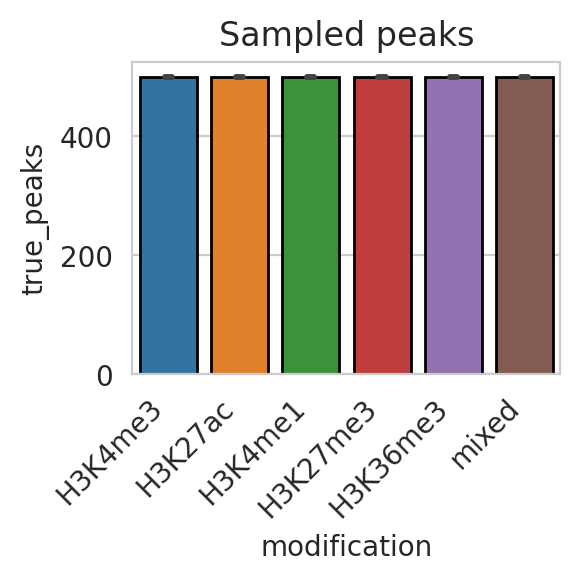

In [132]:
fig = plt.figure(figsize=(3, 3))
sns.barplot(data=df_peaks, x="modification", y="true_peaks",
            capsize=.1, errwidth=2, edgecolor="black",
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled peaks')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_number.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [133]:
ts = []
for m, file in original_peaks.items():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_original = pd.concat(ts).reset_index(drop=True)
del ts
t_original

length modification
0         244      H3K4me3
1         560      H3K4me3
2         280      H3K4me3
3        1346      H3K4me3
4        1941      H3K4me3
...       ...          ...
99995    4999     H3K36me3
99996    7399     H3K36me3
99997   28599     H3K36me3
99998   31799     H3K36me3
99999    9999     H3K36me3

[100000 rows x 2 columns]

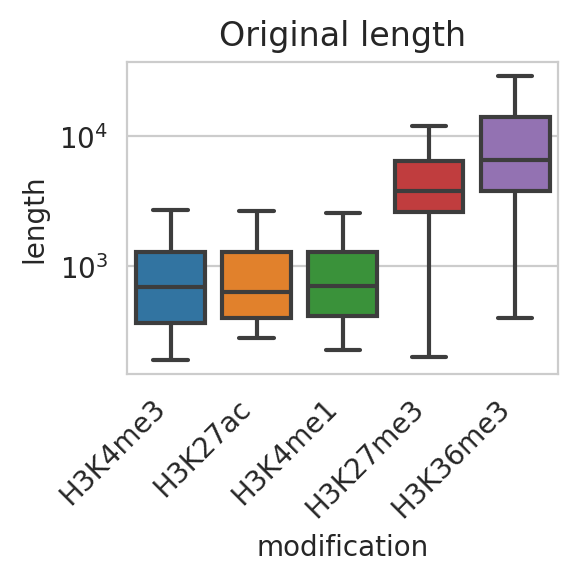

In [134]:
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
sns.boxplot(data=t_original, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            ax=ax)
ax.set(yscale='log')
plt.xticks(rotation=45, ha='right')
plt.title('Original length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

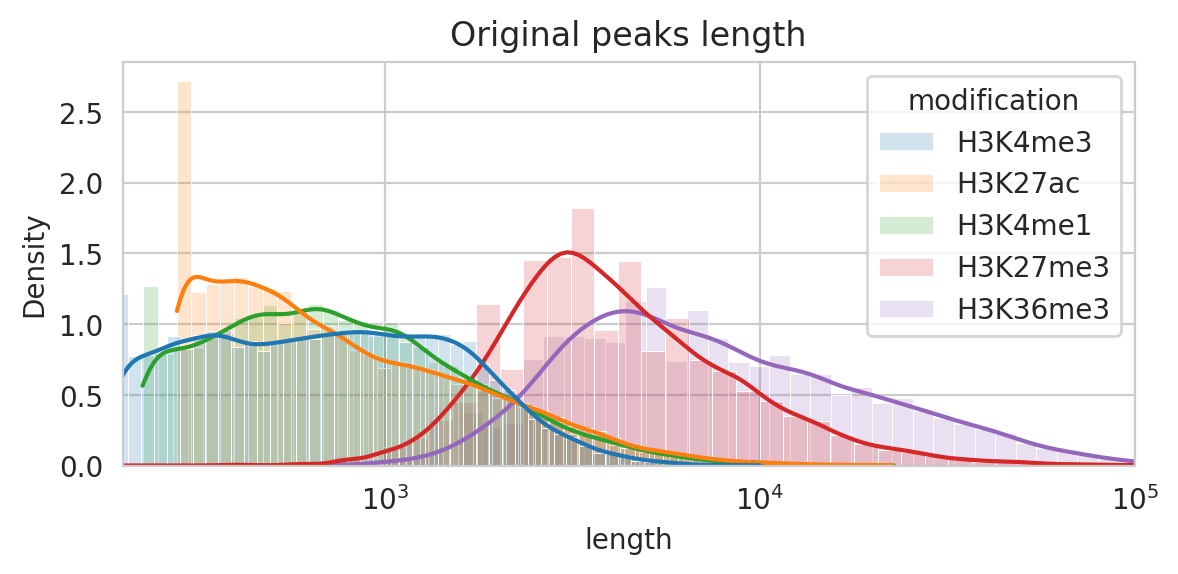

In [135]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t_original, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Original peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [136]:
ts = []
for _, (m, file) in df_peaks[['modification', 'true_peaks_file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_true_peaks = pd.concat(ts).reset_index(drop=True)
del ts
t_true_peaks

length modification
0         1369      H3K4me3
1          385      H3K4me3
2          368      H3K4me3
3         1595      H3K4me3
4         1355      H3K4me3
...        ...          ...
299995    2551        mixed
299996     878        mixed
299997    1710        mixed
299998    1385        mixed
299999    1547        mixed

[300000 rows x 2 columns]

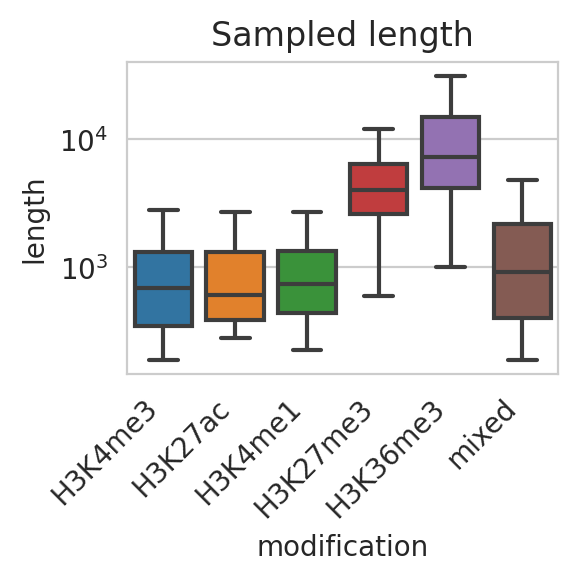

In [137]:
fig = plt.figure(figsize=(3, 3))
g_results = sns.boxplot(data=t_true_peaks, x="modification", y="length", showfliers=False,
               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
g_results.set(yscale='log')
plt.title('Sampled length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

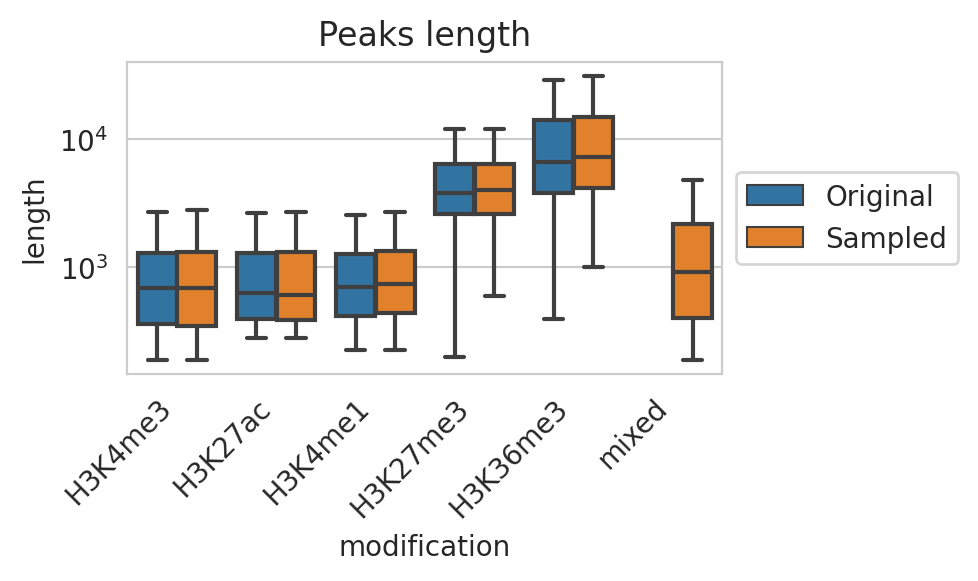

In [138]:
t_original['type'] = 'Original'
t_true_peaks['type'] = 'Sampled'
plt.figure(figsize=(5, 3))
g_results = sns.boxplot(data=pd.concat([t_original, t_true_peaks]).reset_index(drop=True), 
                        x="modification", y="length", showfliers=False,
                        hue='type', hue_order=['Original', 'Sampled'],
                        order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
# Put a legend to the right of the current axix
g_results.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
g_results.set(yscale='log')
plt.title('Peaks length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

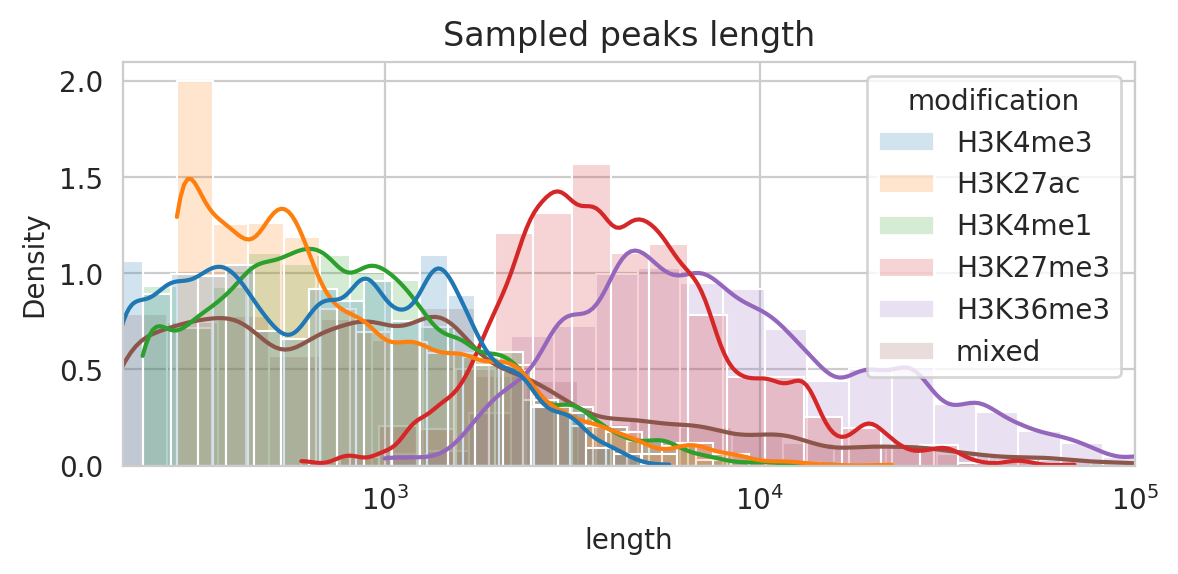

In [139]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t_true_peaks, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=20, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Sampled peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

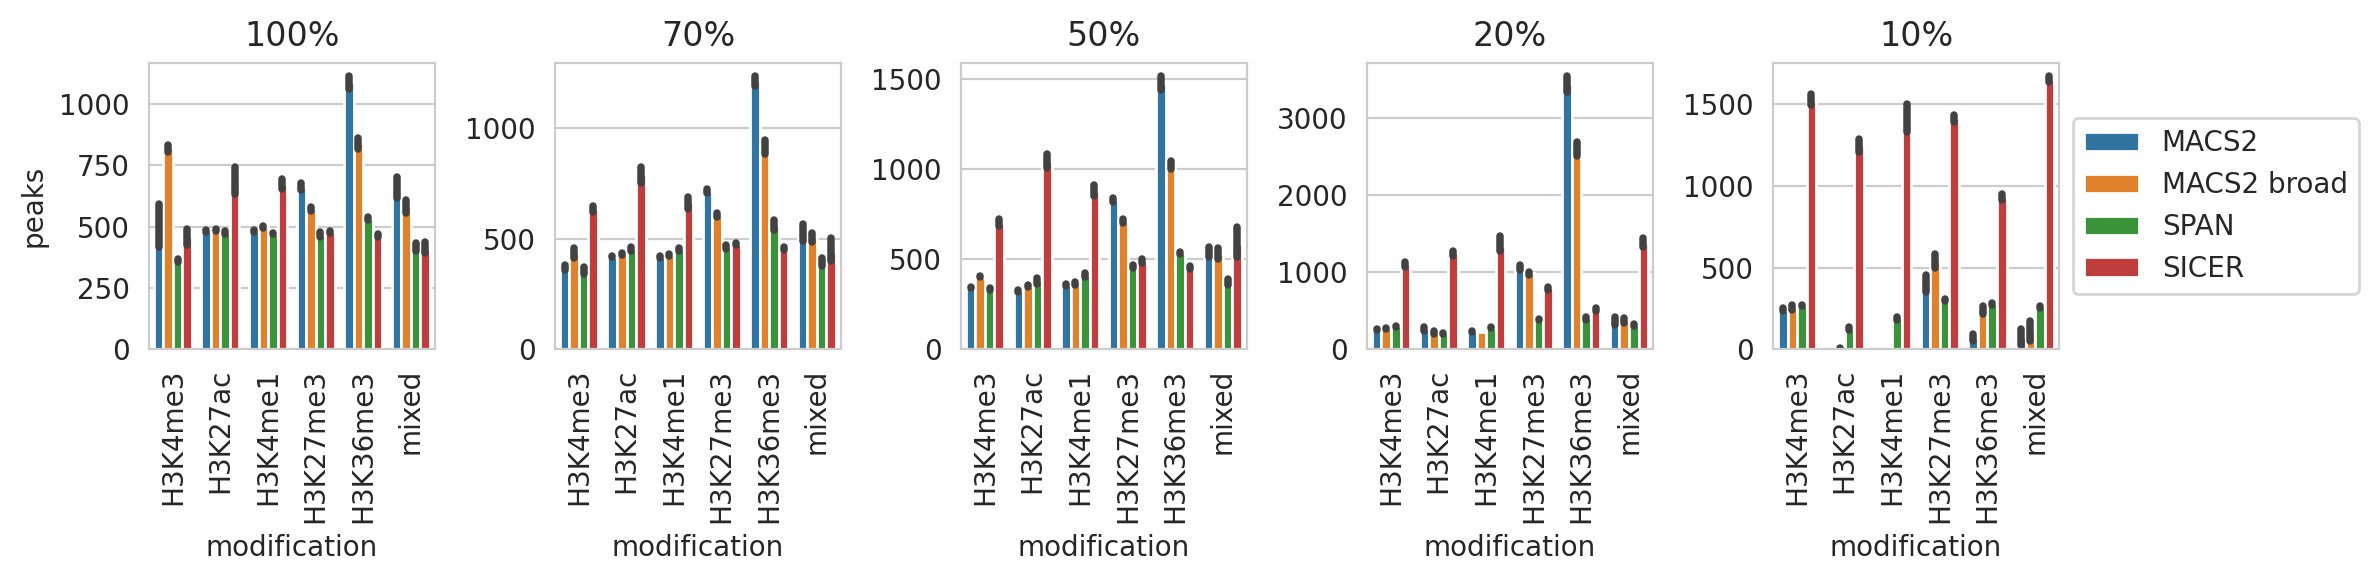

In [140]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="peaks", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [141]:
ts = []
for _, (m, q, tool, file) in df_peaks[['modification', 'quality', 'tool', 'file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    t['quality'] = q
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

length modification quality   tool
0       1131.0      H3K4me3    100%  MACS2
1        193.0      H3K4me3    100%  MACS2
2        193.0      H3K4me3    100%  MACS2
3        327.0      H3K4me3    100%  MACS2
4        193.0      H3K4me3    100%  MACS2
...        ...          ...     ...    ...
353412  1599.0        mixed     10%  SICER
353413  1599.0        mixed     10%  SICER
353414   999.0        mixed     10%  SICER
353415  1399.0        mixed     10%  SICER
353416  2199.0        mixed     10%  SICER

[353417 rows x 4 columns]

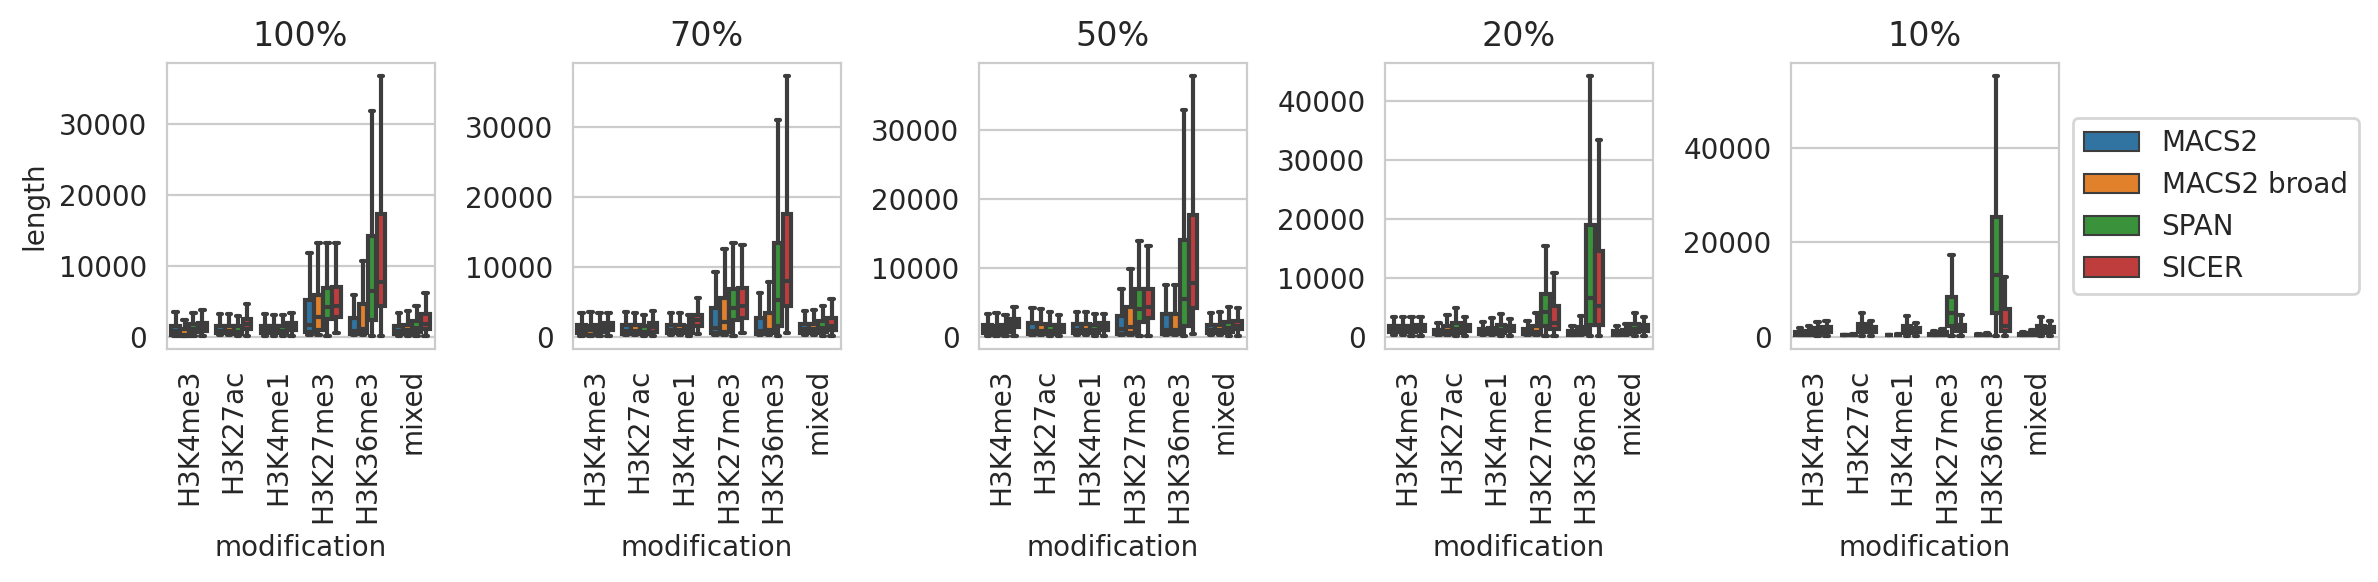

In [142]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.boxplot(data=t[t['quality']==q], x="modification", y="length", hue='tool', showfliers=False, ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard, precision, recall, F1

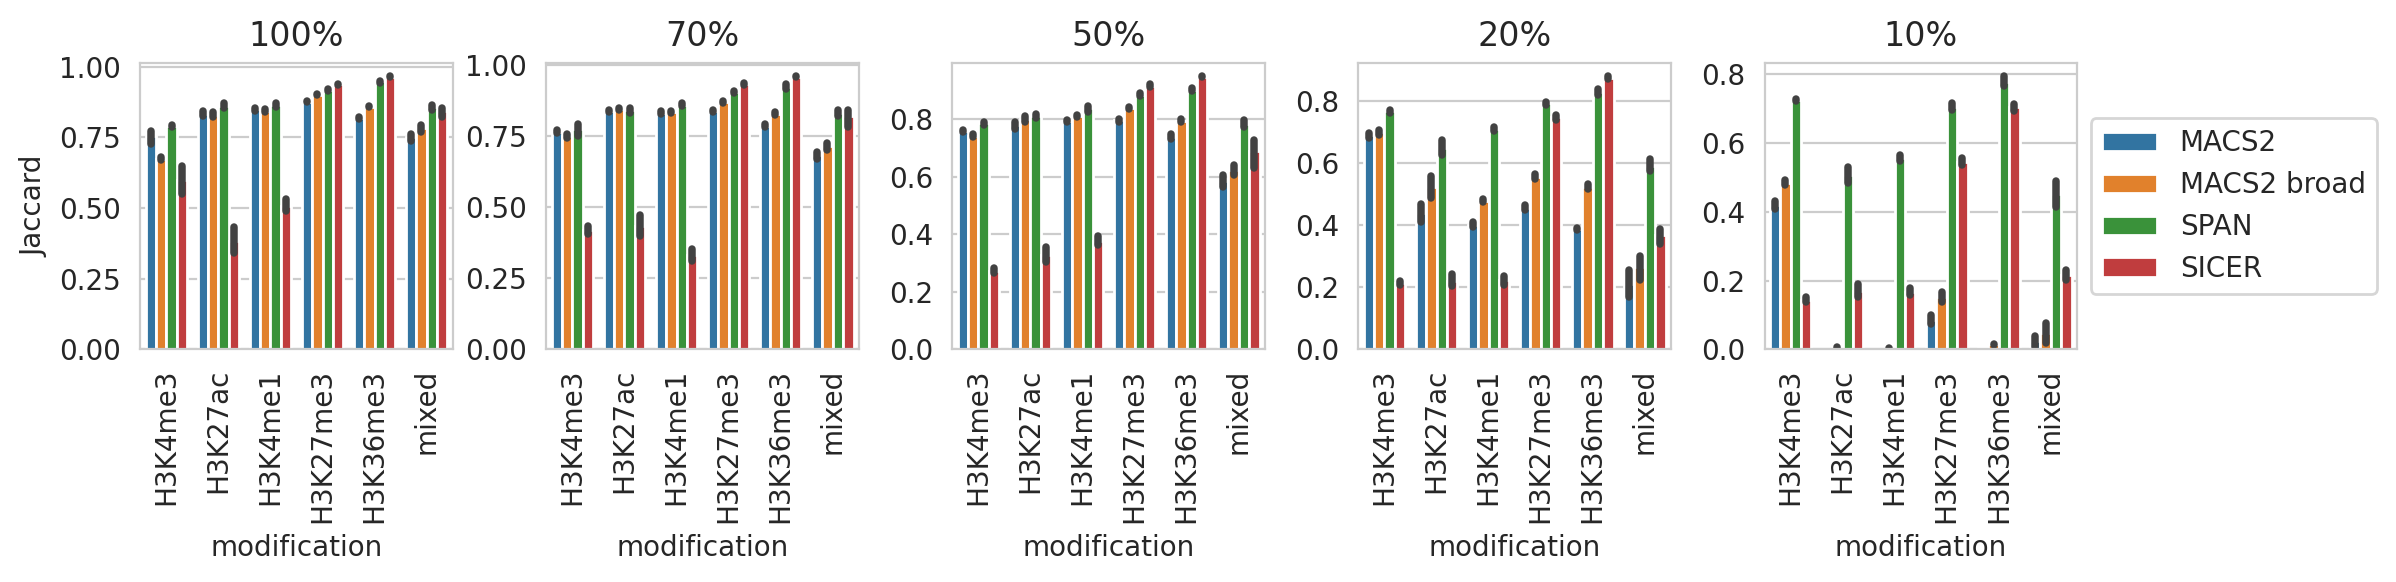

In [143]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="Jaccard", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [144]:
df_peaks0 = df_peaks.copy()
# Add 0.0 multiplier
for m, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], TOOLS):
    row = [None, m, None, 0.0, tool, '0%'] + [None] * (len(df_peaks.columns) - 7) + [0.0]
    df_peaks0.loc[len(df_peaks0)] = row
df_peaks0

file modification     n  \
0    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
1    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
2    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
3    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
4    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
..                                                 ...          ...   ...   
619                                               None     H3K36me3  None   
620                                               None        mixed  None   
621                                               None        mixed  None   
622                                               None        mixed  None   
623                                               None        mixed  None   

     multiplier         tool quality  \
0           1.0        MACS2    100%   
1           0.7        MACS2     70%   
2           0.5        MACS2     50%   
3           0.2        MACS2     20%   
4           0.1        MACS2     10%   
..          ...          ...     ...   
619         0.0        SICER      0%   
620         0.0        MACS2      0%   
621         0.0  MACS2 broad      0%   
622         0.0         SPAN      0%   
623         0.0        SICER      0%   

                                       true_peaks_file true_peaks true_length  \
0    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      456283   
1    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      456283   
2    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      456283   
3    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      456283   
4    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      456283   
..                                                 ...        ...         ...   
619                                               None       None        None   
620                                               None       None        None   
621                                               None       None        None   
622                                               None       None        None   
623                                               None       None        None   

    peaks    length true_overlap overlap overlap_len Precision Recall  \
0     708  564059.0          392     396      419179  0.559322  0.784   
1     388  471628.0          356     363      402785  0.935567  0.712   
2     352  446348.0          331     336      388042  0.954545  0.662   
3     264  365008.0          250     260      332585  0.984848    0.5   
4     248  209629.0          186     240      198742  0.967742  0.372   
..    ...       ...          ...     ...         ...       ...    ...   
619  None      None         None    None        None      None   None   
620  None      None         None    None        None      None   None   
621  None      None         None    None        None      None   None   
622  None      None         None    None        None      None   None   
623  None      None         None    None        None      None   None   

           F1   Jaccard  
0    0.652872  0.697280  
1    0.808615  0.767025  
2    0.781802  0.754081  
3    0.663265  0.680542  
4    0.537417  0.425417  
..        ...       ...  
619      None  0.000000  
620      None  0.000000  
621      None  0.000000  
622      None  0.000000  
623      None  0.000000  

[624 rows x 18 columns]

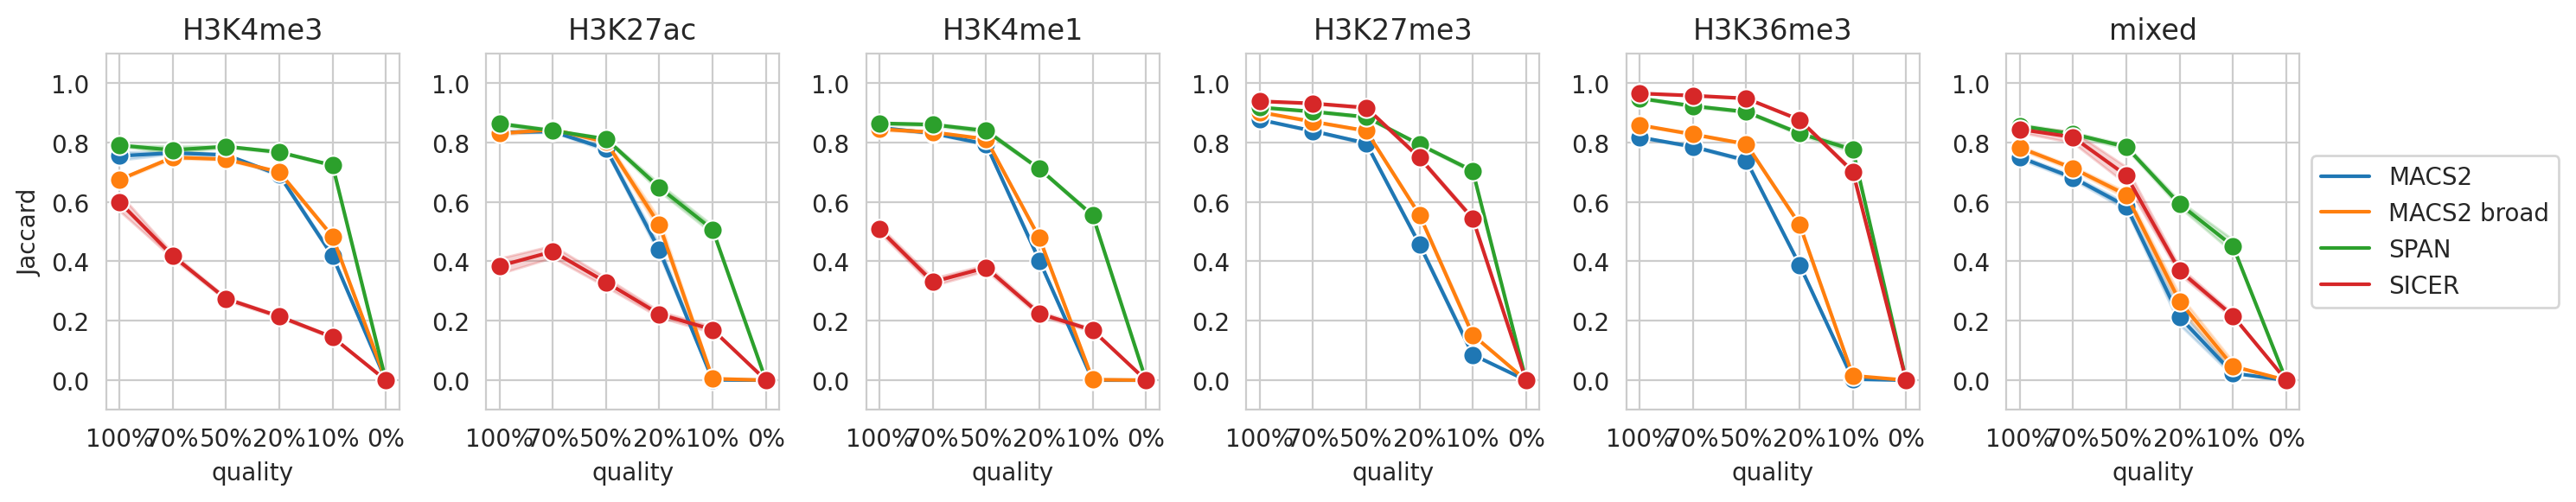

In [145]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=df_peaks0[df_peaks0['modification'] == m], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8)
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

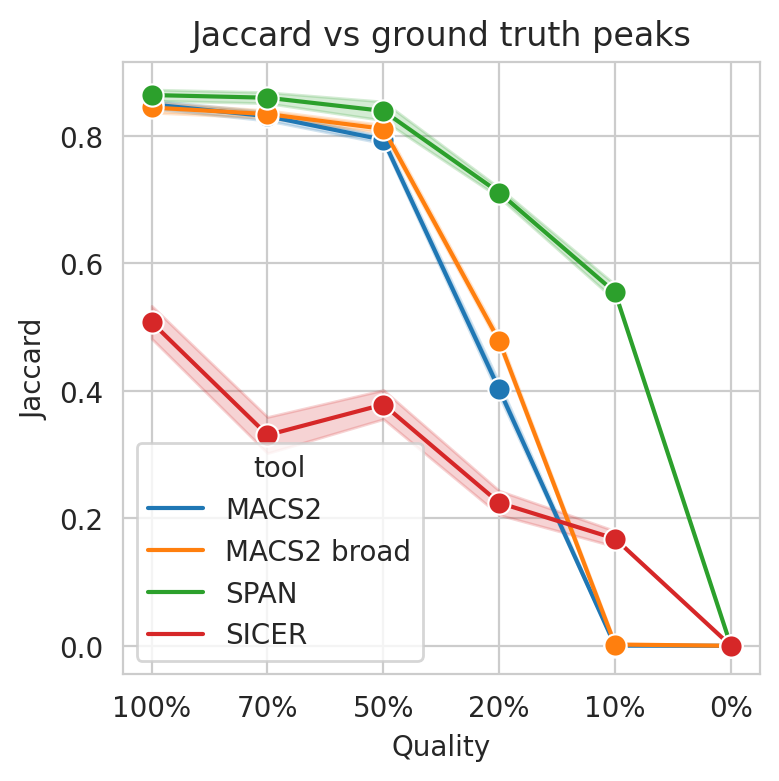

In [146]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks0[df_peaks0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

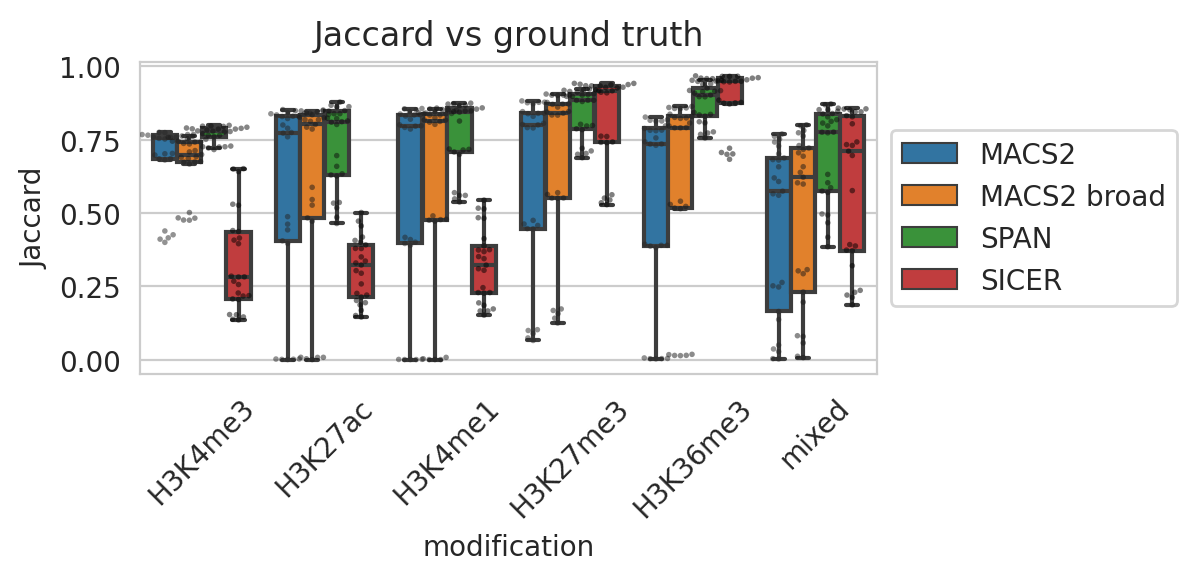

In [147]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=df_peaks[df_peaks['multiplier'] > 0],
            x='modification', y='Jaccard', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            palette=TOOLS_PALETTE,
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_peaks[df_peaks['multiplier'] > 0],
              x='modification', y='Jaccard', hue='tool',
              dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard vs ground truth')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard3.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard AUC vs quality

In [148]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n         tool       AUC
76      H3K4me1  5        MACS2  0.615920
65      H3K4me1  2  MACS2 broad  0.637036
42     H3K36me3  1        SICER  0.865407

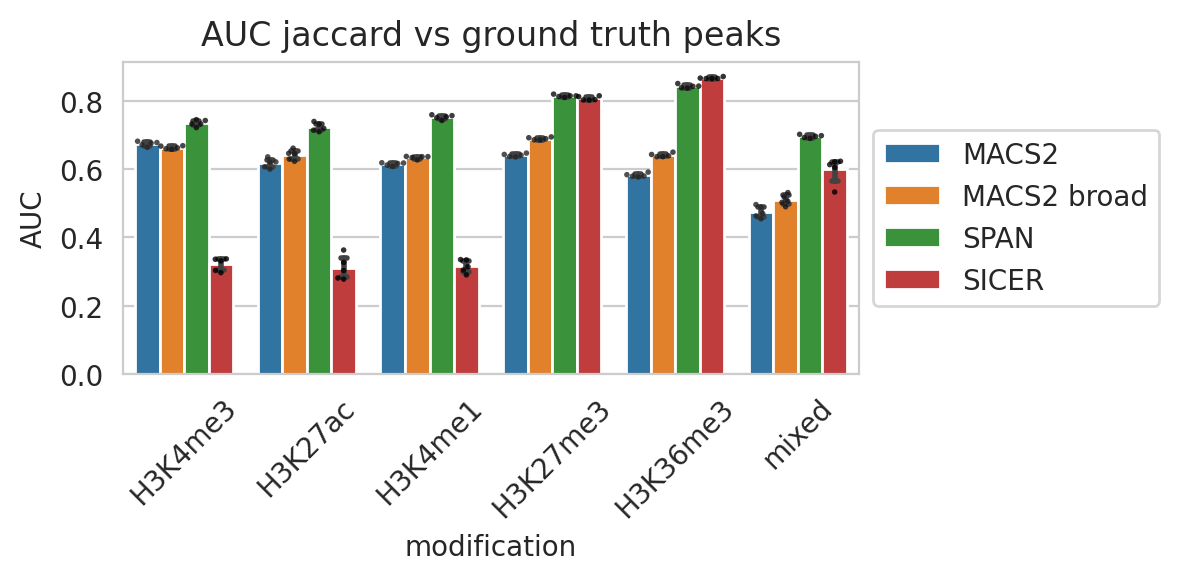

In [149]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs ground truth peaks')
sns.barplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
            capsize=.05, errwidth=2,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

Precision


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


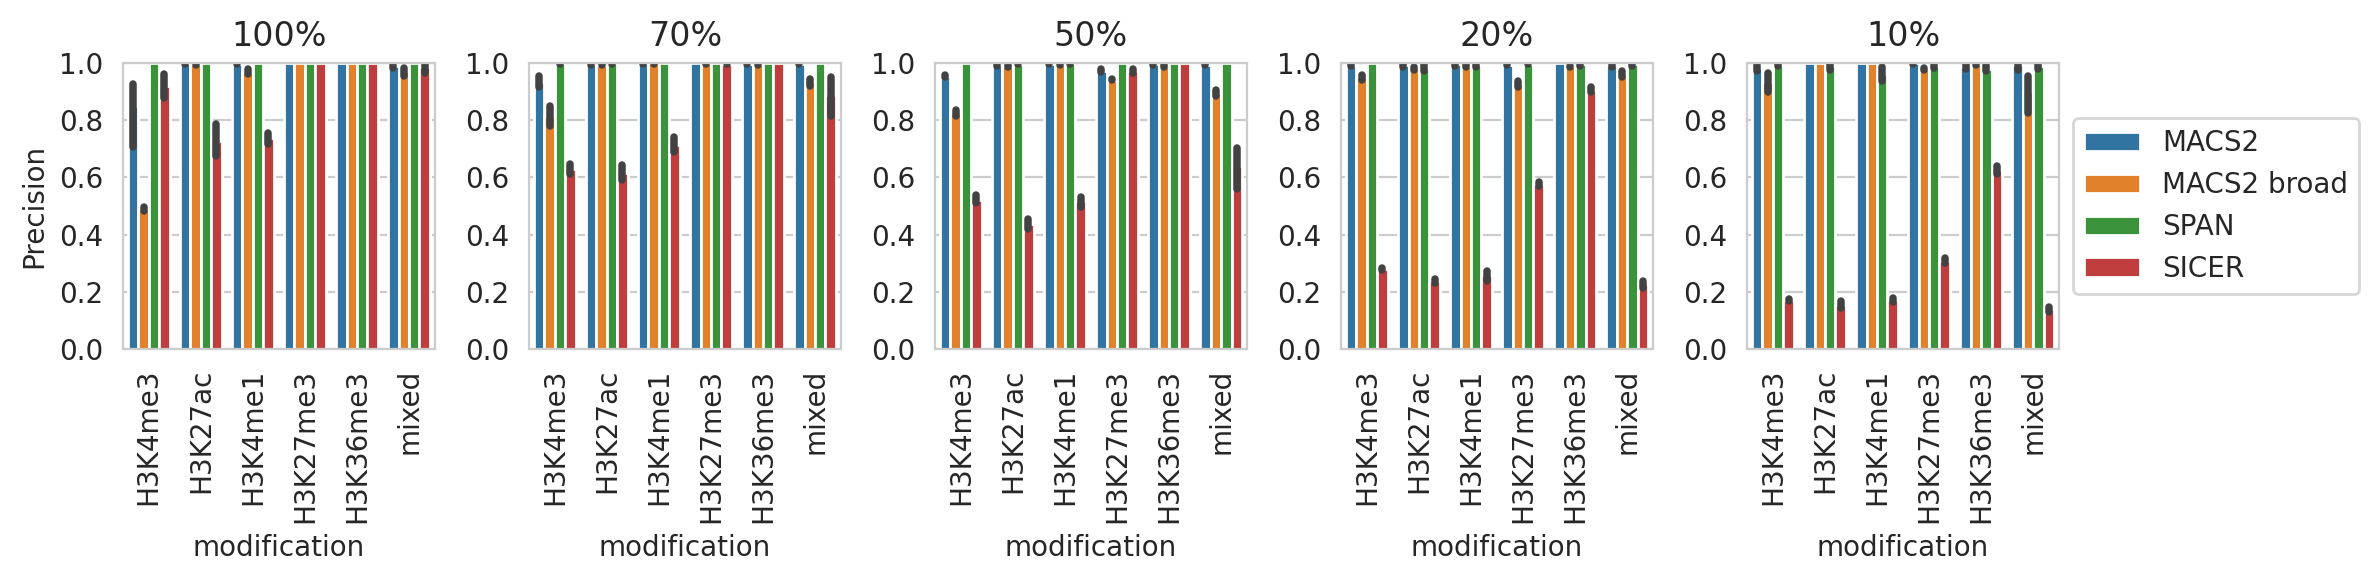

Recall


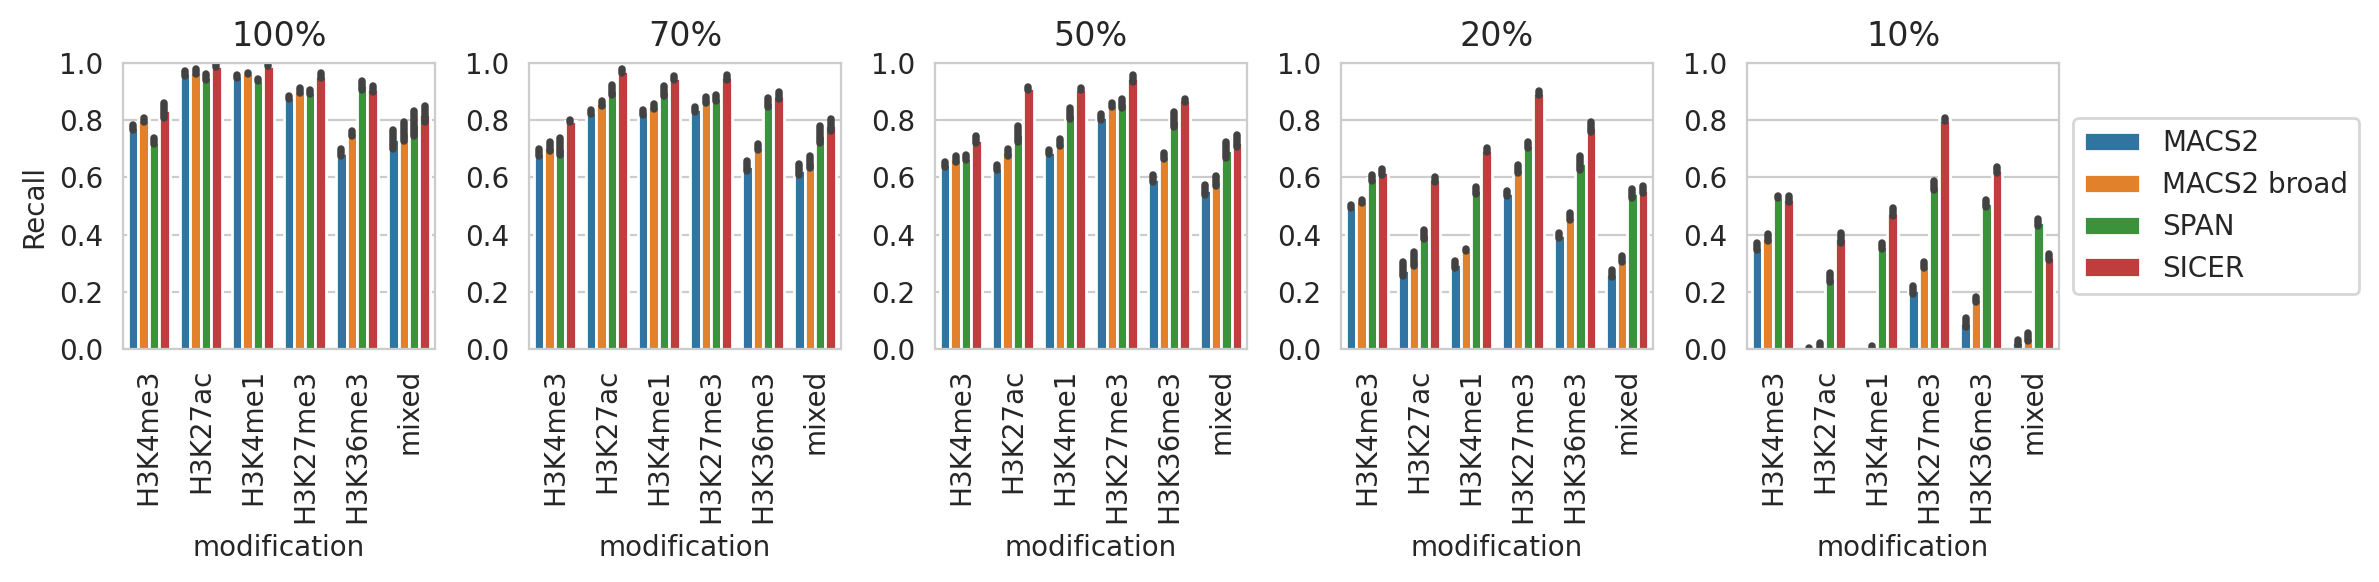

F1


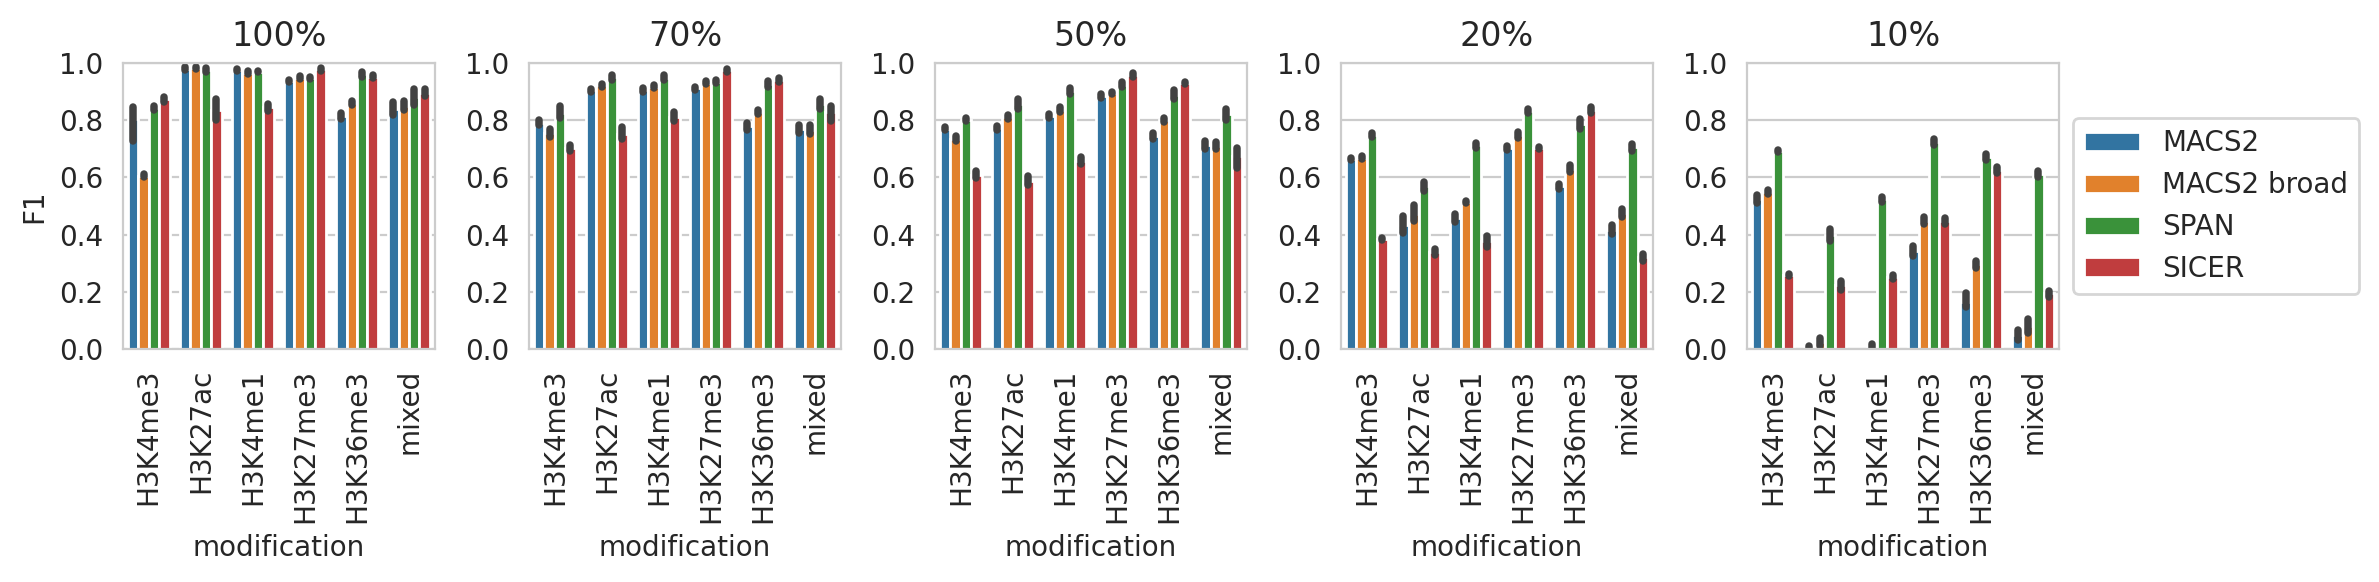

In [150]:
for y in ['Precision', 'Recall', 'F1']:
    print(y)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, q in enumerate(df_peaks['quality'].unique()):
        if q == '0%':
            continue
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['quality'] == q)], x="modification", y=y, hue='tool', ax=ax,
                    order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_title(f'{q}')
        # Put a legend to the right of the current axis
        if i == len(axs) - 1:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
        if i > 0:
            ax.set_ylabel(None)
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{y}.pdf'), bbox_inches='tight', dpi=300)
    plt.show()

/tmp/ipykernel_3046370/1893111183.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


  0%|          | 0/6 [00:00<?, ?it/s]

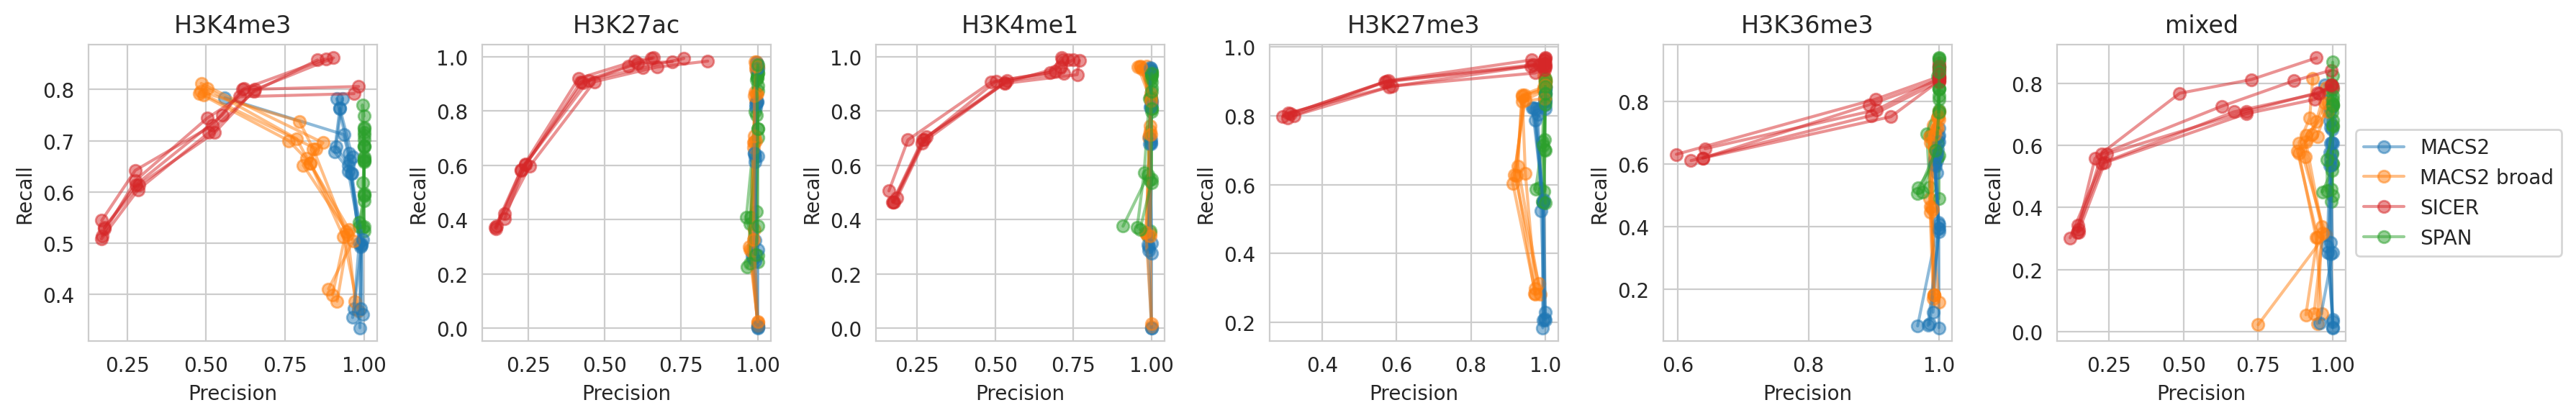

In [151]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for (n, tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['n', 'tool']):
        if m == 'mixed' and tool not in labels:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.5)
            labels.append(tool)
        else:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', color=TOOLS_PALETTE[tool], alpha=0.5)
        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title(f'{m}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_3046370/1888415738.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_3046370/1888415738.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['tool']):
/tmp/ipykernel_3046370/1888415738.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['tool']):
/tmp/ipykernel_3046370/1888415738.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (tool), dft in df_peaks[df_peaks['modification'] == m]

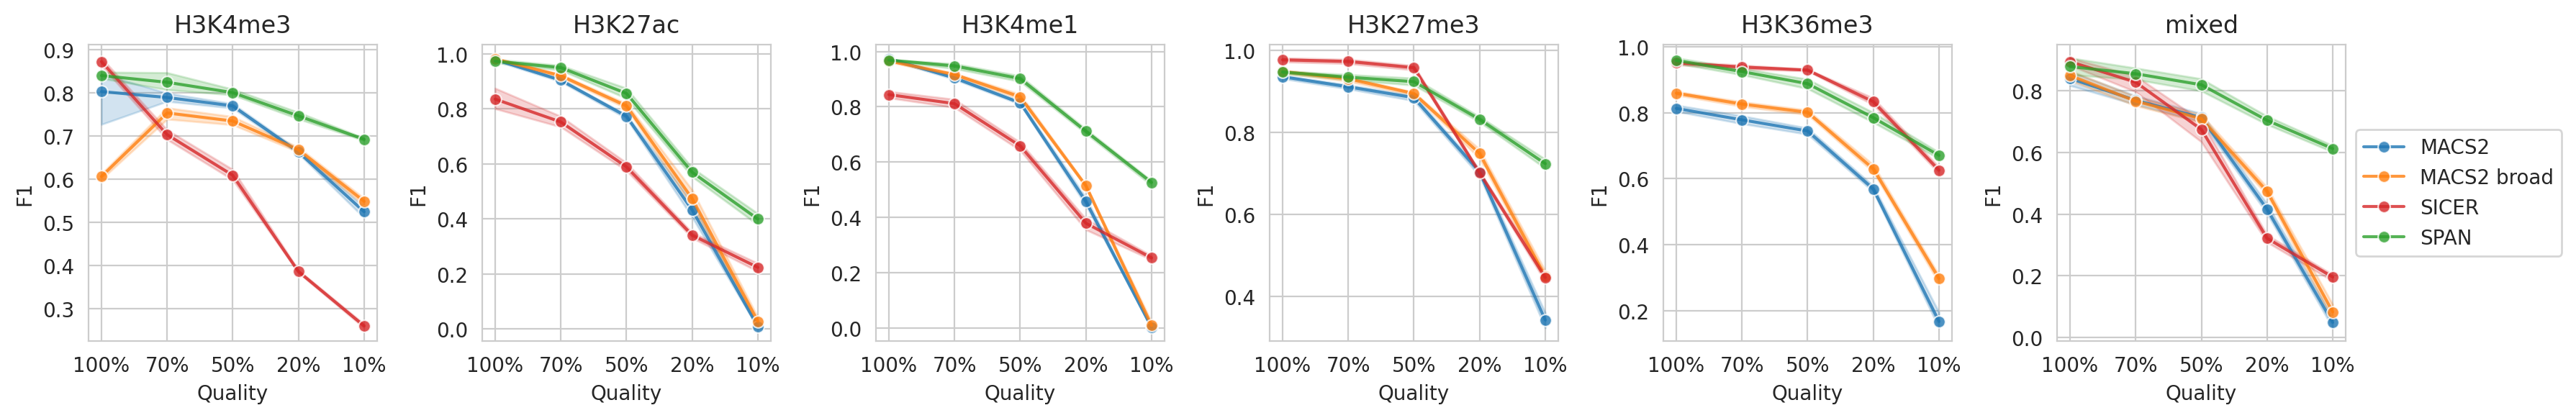

In [152]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once 
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for (tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['tool']):
        if m == 'mixed' and tool not in labels:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
            labels.append(tool)
        else:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
    ax.set_xlabel('Quality')
    ax.set_ylabel('F1')
    ax.set_title(f'{m}')
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))        
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

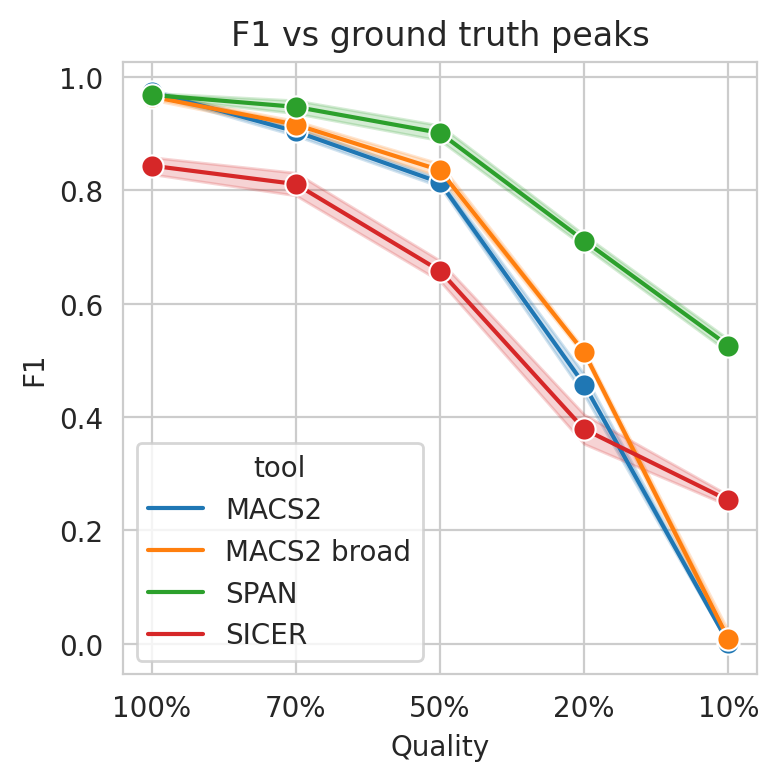

In [153]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks[df_peaks['modification'] == 'H3K4me1'], x="quality", y="F1", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('F1 vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('F1')
plt.tight_layout()
plt.show()

In [154]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    f1prev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['F1'] + f1prev) / 2
        mprev, f1prev = row['multiplier'], row['F1']
    t.append((m, n, tool, aj))
dff1auc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dff1auc.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n         tool       AUC
105        mixed  2  MACS2 broad  0.615756
68       H3K4me1  3        MACS2  0.668453
93       H3K4me3  4  MACS2 broad  0.653281

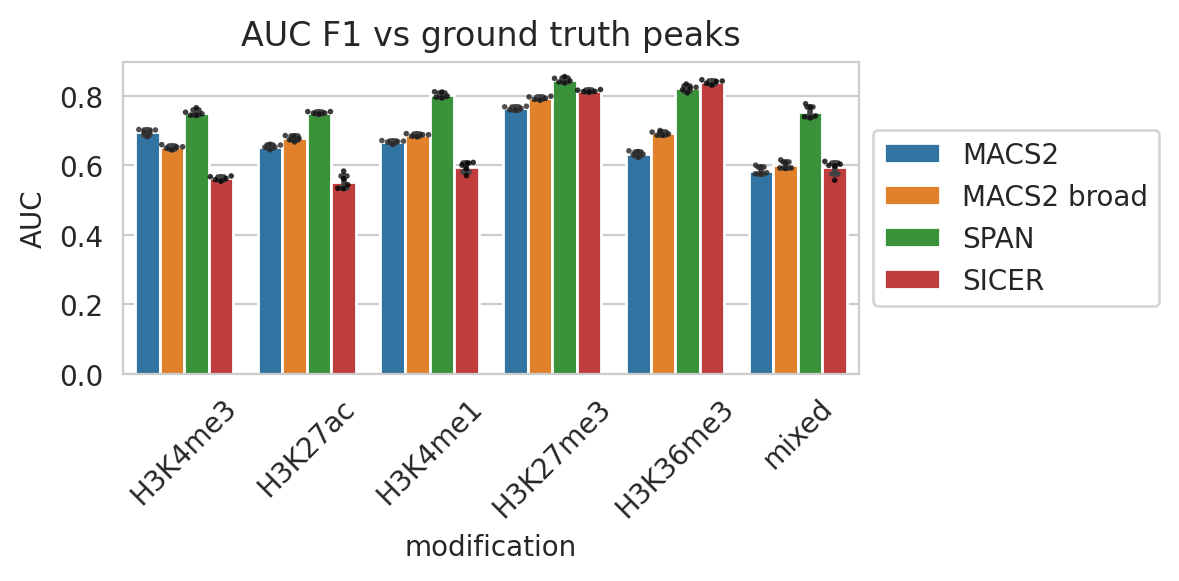

In [155]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC F1 vs ground truth peaks')
sns.barplot(data=dff1auc, x='modification', y='AUC',hue='tool',
            capsize=.05, errwidth=2,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dff1auc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8,
              palette="dark:black",
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Overlap vs 100% quality peaks

In [156]:
rows = []
tf = tempfile.mktemp()
for (m, n, t), dft in tqdm(df_peaks.groupby(['modification', 'n', 'tool'])):
    print(m, n, t)
    peaks_file100 = dft[dft['multiplier'] == 1.0]['file'].values[0]
    for _, (file, mult) in dft[dft['multiplier'] != 1.0][['file', 'multiplier']].iterrows():
        peaks100 = lines(peaks_file100)
        length100 = bedl(peaks_file100).sum()
        peaks = lines(file)
        length = bedl(file).sum()
        peaks_file100_s = sorted_file(peaks_file100)
        file_s = sorted_file(file)
        !bedtools intersect -a {peaks_file100_s} -b {file_s} -wa -u > {tf}
        overlap100 = lines(tf)
        !bedtools intersect -b {peaks_file100_s} -a {file_s} -wa -u > {tf}
        overlap = lines(tf)
        !bedtools intersect -a {peaks_file100_s} -b {file_s} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        rows.append((m, n, t, mult, peaks_file100, peaks100, length100, peaks, length, overlap100, overlap, overlap_len))

overlap100_df = pd.DataFrame(rows, columns=['modification', 'n', 'tool', 'multiplier',
                             'peaks_file100', 'peaks100', 'length100',
                             'peaks', 'length',
                             'overlap100', 'overlap', 'overlap_len'])
del rows

overlap100_df['Precision'] = overlap100_df['overlap'] / overlap100_df['peaks']
overlap100_df['Recall'] = overlap100_df['overlap100'] / overlap100_df['peaks100']
overlap100_df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(overlap100_df['Precision'], overlap100_df['Recall'])]
overlap100_df['Jaccard'] = overlap100_df['overlap_len'] / (overlap100_df['length100'] + overlap100_df['length'] - overlap100_df['overlap_len'])
overlap100_df['quality'] = [f'{int(m * 100)}%' for m in overlap100_df['multiplier']]

overlap100_df.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 SICER
H3K27ac 1 SPAN
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 SICER
H3K27ac 2 SPAN
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 SICER
H3K27ac 3 SPAN
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 SICER
H3K27ac 4 SPAN
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 SICER
H3K27ac 5 SPAN
H3K27me3 1 MACS2
H3K27me3 1 MACS2 broad
H3K27me3 1 SICER
H3K27me3 1 SPAN
H3K27me3 2 MACS2
H3K27me3 2 MACS2 broad
H3K27me3 2 SICER
H3K27me3 2 SPAN
H3K27me3 3 MACS2
H3K27me3 3 MACS2 broad
H3K27me3 3 SICER
H3K27me3 3 SPAN
H3K27me3 4 MACS2
H3K27me3 4 MACS2 broad
H3K27me3 4 SICER
H3K27me3 4 SPAN
H3K27me3 5 MACS2
H3K27me3 5 MACS2 broad
H3K27me3 5 SICER
H3K27me3 5 SPAN
H3K36me3 1 MACS2
H3K36me3 1 MACS2 broad
H3K36me3 1 SICER
H3K36me3 1 SPAN
H3K36me3 2 MACS2
H3K36me3 2 MACS2 broad
H3K36me3 2 SICER
H3K36me3 2 SPAN
H3K36me3 3 MACS2
H3K36me3 3 MACS2 broad
H3K36me3 3 SICER
H3K36me3 3 SPAN
H3K36me3 4 MACS2
H3K36me3 4 MACS2 broad
H3K36me3 4 SICER
H3K36me3 4 SPA

modification  n         tool  multiplier  \
130     H3K27me3  4        MACS2         0.2   
324      H3K4me3  1  MACS2 broad         0.7   
106     H3K27me3  2        SICER         0.2   

                                         peaks_file100  peaks100  length100  \
130  /home/jetbrains/data/2023_chips/macs2/H3K27me3...       677    2639939   
324  /home/jetbrains/data/2023_chips/macs2/H3K4me3_...       825     599560   
106  /home/jetbrains/data/2023_chips/sicer/H3K27me3...       483    2856917   

     peaks     length  overlap100  overlap  overlap_len  Precision    Recall  \
130   1093  1400502.0         302     1086      1396981   0.993596  0.446086   
324    464   498554.0         367      367       472113   0.790948  0.444848   
106    800  3277800.0         447      459      2629541   0.573750  0.925466   

           F1   Jaccard quality  
130  0.615732  0.528467     20%  
324  0.569434  0.754173     70%  
106  0.708352  0.750188     20%

In [157]:
overlap100_df0 = overlap100_df.copy()
# Add 1.0 and 0.0 multiplier
for m, n, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], range(1, 6), TOOLS):
    row = [m, n, tool, 0.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    row = [m, n, tool, 1.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'quality'] = '0%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'quality'] = '100%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'Jaccard'] = 0
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'Jaccard'] = 1
overlap100_df0.sort_values(by=['modification', 'n', 'tool', 'multiplier'], ascending=False, inplace=True)
overlap100_df0.tail(3)

modification  n   tool  multiplier  \
2        H3K27ac  1  MACS2         0.2   
3        H3K27ac  1  MACS2         0.1   
520      H3K27ac  1  MACS2         0.0   

                                         peaks_file100 peaks100 length100  \
2    /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      487    626715   
3    /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      487    626715   
520                                               None     None      None   

    peaks    length overlap100 overlap overlap_len Precision    Recall  \
2     232  218623.0        129     229      217567  0.987069  0.264887   
3       1     337.0          1       1         337       1.0  0.002053   
520  None      None       None    None        None      None      None   

           F1   Jaccard quality  
2    0.417685  0.346571     20%  
3    0.004098  0.000538     10%  
520      None         0      0%

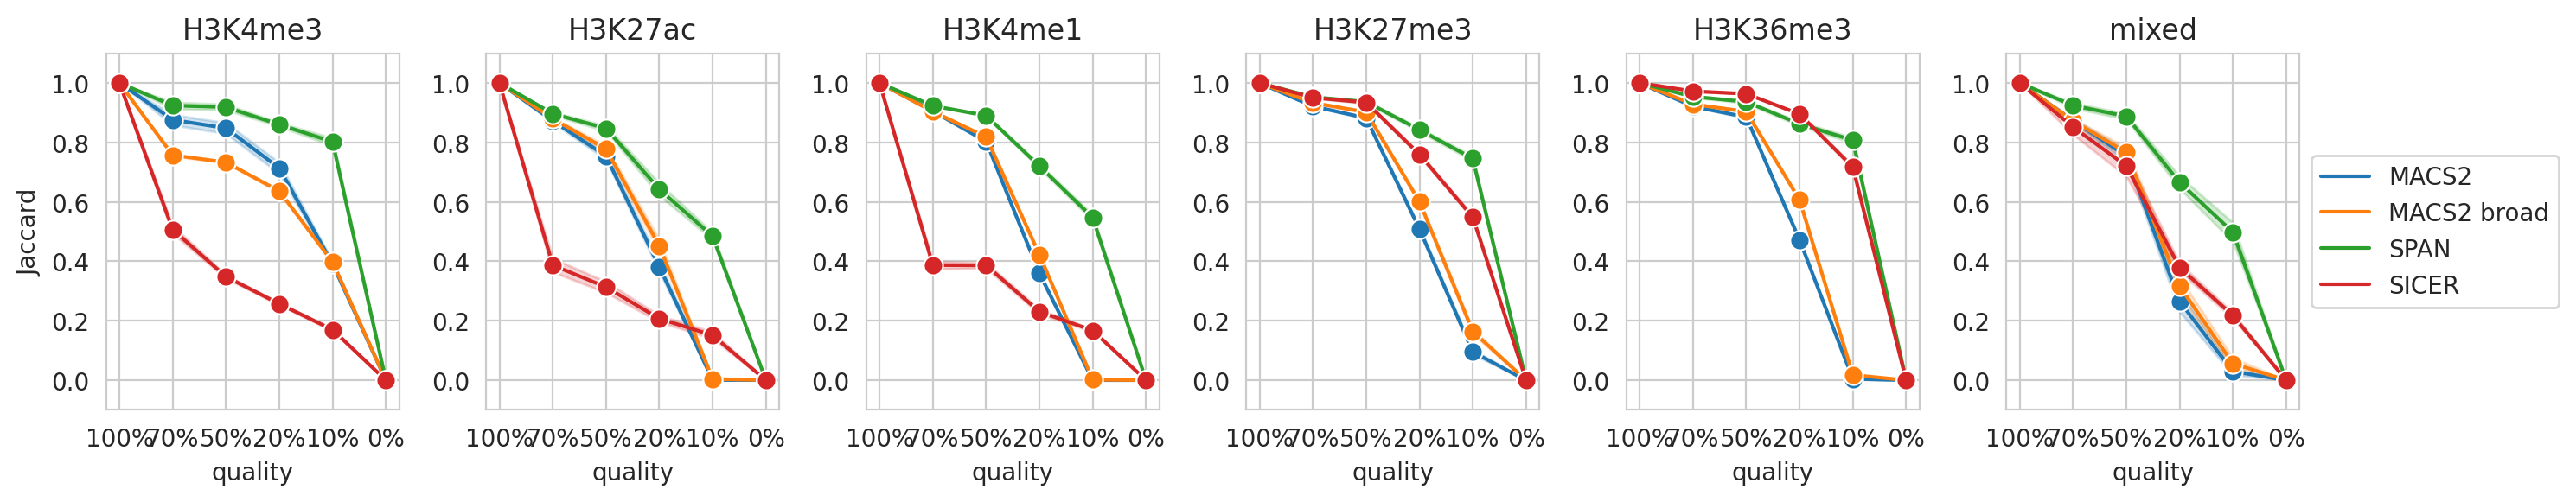

In [158]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=overlap100_df0[overlap100_df0['modification'] == m], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8)
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

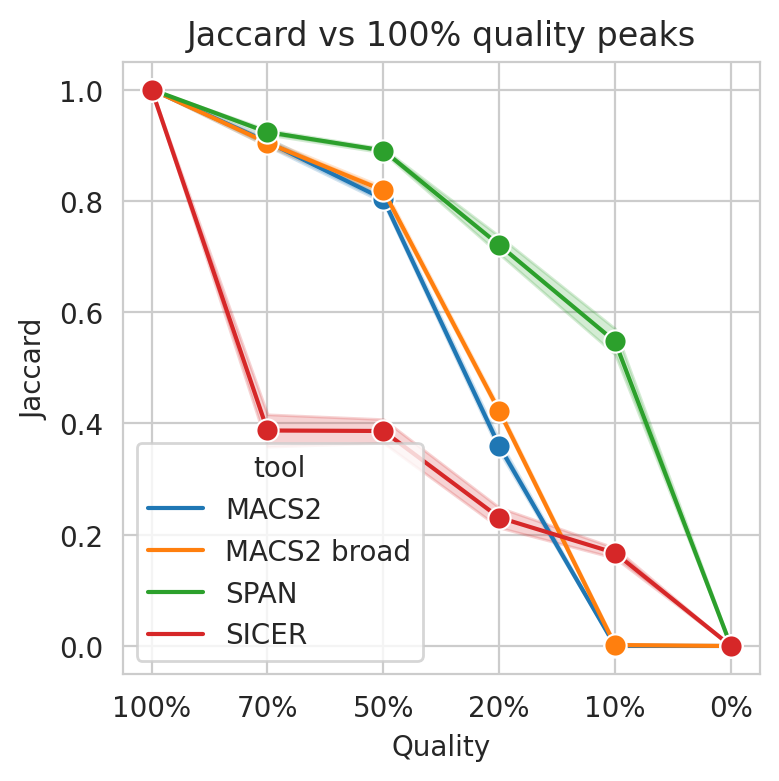

In [159]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=overlap100_df0[overlap100_df0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs 100% quality peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [160]:
t = []
for (m, n, tool), dft in tqdm(list(overlap100_df0[overlap100_df0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc100 = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc100.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n   tool       AUC
92      H3K4me3  4  MACS2  0.779548
54     H3K36me3  4  SICER  0.882455
44     H3K36me3  2  MACS2  0.696797

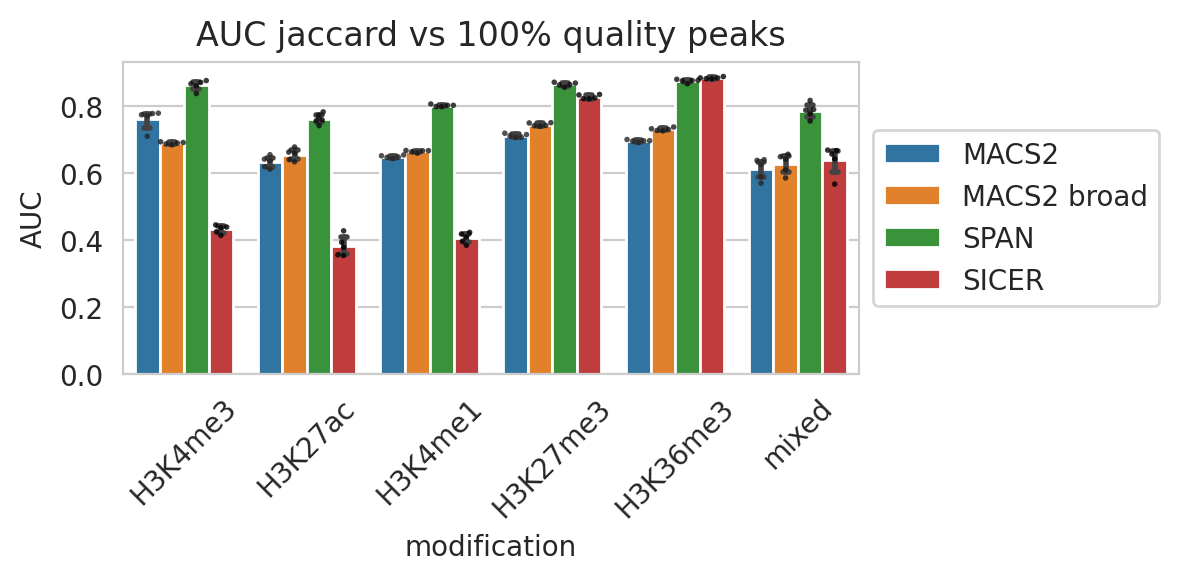

In [161]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs 100% quality peaks')
sns.barplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
            capsize=.05, errwidth=2,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [162]:
dfjaccardauc100[(dfjaccardauc100['modification'] == 'mixed') & (dfjaccardauc100['tool'] == 'SPAN')]

modification  n  tool       AUC
103        mixed  1  SPAN  0.777376
107        mixed  2  SPAN  0.755947
111        mixed  3  SPAN  0.790619
115        mixed  4  SPAN  0.788433
119        mixed  5  SPAN  0.817567